In [1]:
# Install part
!pip install torch torchvision matplotlib tqdm numpy

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59bf6000 @  0x7f6ee5e3c1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 17.1MB/s 
    100% |████████████████████████████████| 2.0MB 3.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Defining U-net model
### Code for training and inference

  0%|          | 0/6710 [00:00<?, ?it/s]

0.124240896


epoch:9, loss:0.2036, accuracy:0.9299183: 100%|██████████| 6710/6710 [3:26:06<00:00,  1.78s/it]


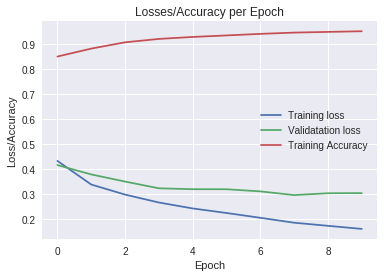

Accuracy: tensor(0.9481, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CancerDetection. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


3059

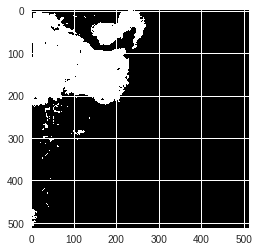

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

# Instruct matplotlib to draw inline
%matplotlib inline

# See if the cuda is avaliable and store it in device
assert torch.cuda.is_available(), "Change to gpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Dataset section
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)


# Ploting the train loss
def plot_both_loss(loss, vloss, acc):
  x = range(len(loss))
  plt.plot(x, loss, label='Training loss')
  plt.plot(x, vloss, label='Validatation loss')
  plt.plot(x, acc, label='Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss/Accuracy')
  plt.title("Losses/Accuracy per Epoch")
  plt.legend()
  plt.show()

    
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.train = train
    
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
 
  def __len__(self):
    return  len(self.dataset_folder)

  
class CancerDetection(nn.Module):
  def __init__(self, trainset):
    super(CancerDetection, self).__init__()
 
    # First conv block
    self.conv2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
    
    # First max pool block
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Second conv block
    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
      
    # Second max pool block
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Third conv block
    self.conv6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
    
    # Third max pool block
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fourth conv block
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
    
    # Fourth max pool block
    self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fifth conv block
    self.conv10 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU())
    
    ## Now time for transposed convolution
    # First transposed convolution
    self.upconv1 = nn.ConvTranspose2d(
        1024, 512, kernel_size = 2, stride = 2, padding = 0)
    
    # Sixth conv block
    self.conv12 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
    
    # Second transposed convolution
    self.upconv2 = nn.ConvTranspose2d(
        512, 256, kernel_size = 2, stride = 2, padding = 0)
    
    # Seventh conv block
    self.conv14 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
    
    # Third transposed convolution
    self.upconv3 = nn.ConvTranspose2d(
        256, 128, kernel_size = 2, stride = 2, padding = 0)
    
    # Eight conv block
    self.conv16 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
    
    # Fourth transposed convolution
    self.upconv4 = nn.ConvTranspose2d(
        128, 64, kernel_size = 2, stride = 2, padding = 0)
    
    # Nineth conv block
    self.conv18 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
    
    # Last layer
    self.conv19 = nn.Sequential(
        nn.Conv2d(64, 2, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU())
    
  def forward(self, input):
    
    first_block_conv = self.conv2(input)
    
    first_maxpool = self.maxpool1(first_block_conv)
    second_block_conv = self.conv4(first_maxpool)
    
    second_maxpool = self.maxpool2(second_block_conv)
    third_block_conv = self.conv6(second_maxpool)
    
    third_maxpool = self.maxpool3(third_block_conv)
    fourth_block_conv = self.conv8(third_maxpool)
    
    fourth_maxpool = self.maxpool4(fourth_block_conv)
    fifth_block_conv = self.conv10(fourth_maxpool)
    
    # Time for transpose convolution
    first_upconv = self.upconv1(fifth_block_conv)
    
    # Concatnate the fourth convolution block to the first upconv block
    first_concat = torch.cat((fourth_block_conv, first_upconv),1)    
    sixth_block_conv = self.conv12(first_concat)
    
    second_upconv = self.upconv2(sixth_block_conv)
    
    # Concatnate the third convolution block to the second upconv block
    second_concat = torch.cat((third_block_conv, second_upconv),1)
    seven_block_conv = self.conv14(second_concat)
    
    third_upconv = self.upconv3(seven_block_conv)
    
    # Concatnate the second convolution block to the third upconv block
    third_concat = torch.cat((second_block_conv, third_upconv),1)
    eight_block_conv = self.conv16(third_concat)
    
    fourth_upconv = self.upconv4(eight_block_conv)
    # Concatnate the first convolution block to the fourth upconv block
    fourth_concat = torch.cat((first_block_conv, fourth_upconv),1)
    nine_block_conv = self.conv18(fourth_concat)
    
    output = self.conv19(nine_block_conv)
    
    return output
    
def main():
  try:
    #your code for calling dataset and dataloader
    
    #Load the training data in this case CancerDataset
    train_dataset = CancerDataset('/tmp/cancer_data',train=True)

    # Load the validation data
    validatation_dataset = CancerDataset('/tmp/cancer_data',train=False)
    
    # Build a neural net module passing this dataset
    
    #model = Network(train_dataset)
    model = CancerDetection(train_dataset)

    # Make sure that this model runs on cuda
    model = model.cuda()

    # pdb.set_trace()
    # Define the loss function. In this case MSELoss
    loss_func = torch.nn.CrossEntropyLoss()

    # Define the optimizer to use. In this case SGD
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Get the training data in a mini-batch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,
        shuffle=False, num_workers=4, pin_memory=True)

    # Get the validatation data in a mini-batch
    valid_loader = torch.utils.data.DataLoader(validatation_dataset, batch_size=2,
        shuffle=True, num_workers=4, pin_memory=True)
    
    # Define a list to store all the losses
    losses = []
    valid_losses = []
    accuracy = []
    loop = tqdm(total=len(train_loader)*10, position=0)
    
    
    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)
 
    for epoch in range(10):
      # Define a list for batch loss
      batch_losses = []
      batch_acc = []
      # For each data batch from training data
      for batch, (x, y_truth) in enumerate(train_loader):
        # batch[0] is the data and 1 is the label
        x=x.cuda(async=True)
        y_truth=y_truth.cuda(async=True)
        # pdb.set_trace()
        # Reset the grad value to zero
        optimizer.zero_grad()

        # Predicted value
        y_hat = model(x)

        # Compute the loss
        #pdb.set_trace()
        loss = loss_func(y_hat, y_truth.long())

        # Propagate the loss backward. Backprop
        loss.backward()
        
        acc = (y_hat.argmax(1) == y_truth.long()).float().mean()
        batch_acc.append(acc)
        
        # print (accuracy)
        # Set the tqdm params
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.7f}'.format(epoch, loss, acc))
        loop.update(1)

        # Append the loss to compute the average
        batch_losses.append(loss.item())
        
        # Update the weights
        optimizer.step()
        
        #gc.collect()
       
      
      val = np.mean([loss_func(model(x.cuda()), y.cuda().long()).item() for x,y in valid_loader])
      
      valid_losses.append(val)
      
      #Call the validatation step
      #valid_loss = validatation_loop()      
      #gc.collect()
      
      # Compute average loss for that batch
      loss = torch.mean(torch.tensor(batch_losses))
      acc = torch.mean(torch.tensor(batch_acc))
      # Append the average loss to draw graph
      losses.append(loss)
      accuracy.append(acc)
      
    # Close the loop display
    loop.close()
      
    # Draw the plot
    plot_both_loss(losses, valid_losses, accuracy)
    
    # Time to test an image
    #testset = CancerDataset(root='/tmp/mycancerdata', train = False)
    
    #pdb.set_trace()
    final_test_img = validatation_dataset[172][0].cuda()
    final_test_label = validatation_dataset[172][1].cuda()
    final_test_img = final_test_img.view(1,*final_test_img.shape)
    test_pred = model(final_test_img)
    test_pred1 = test_pred.argmax(1)
    print ('Accuracy:', (test_pred1 == final_test_label.long()).float().mean())
    image_data = test_pred1.cpu().detach().numpy().squeeze()
    image_data = (1-image_data) * 255
    plt.imshow(image_data)
    
    torch.save(model, 'unet.h5')
    #label_data = final_test_label.cpu().detach().numpy().squeeze()
    #label_data = (1-label_data)*255
    #plt.imshow(label_data)
  except:
    __ITB__()
 
main()
gc.collect()
  

  

#### Above image is the predicted map for the test image 172

### Original Test Label

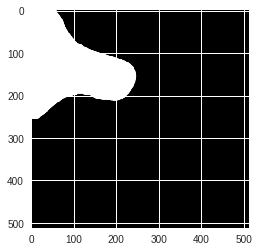

In [10]:
    test_dataset = CancerDataset('/tmp/cancer_data',train=False)
    final_test_label = test_dataset[172][1].cuda()
    image_data = final_test_label.cpu().detach().numpy().squeeze()
    image_data = (1-image_data) * 255
    plt.imshow(image_data)

### Predicted Label

Accuracy: tensor(0.9481, device='cuda:0')


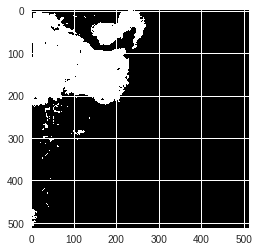

In [11]:
    model = torch.load('unet.h5')
    test_dataset = CancerDataset('/tmp/cancer_data',train=False)
    final_test_img = test_dataset[172][0].cuda()
    final_test_label = test_dataset[172][1].cuda()
    final_test_img = final_test_img.view(1,*final_test_img.shape)
    test_pred = model(final_test_img)
    test_pred1 = test_pred.argmax(1)
    print ('Accuracy:', (test_pred1 == final_test_label.long()).float().mean())
    image_data = test_pred1.cpu().detach().numpy().squeeze()
    image_data = (1-image_data) * 255
    plt.imshow(image_data)

In [0]:
from google.colab import files
files.download("unet.h5")